# Import Library

In [95]:
!pip install openpyxl
!pip install tslearn

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GRU, Dropout, Dense, Conv1D
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from keras.utils.vis_utils import plot_model
import matplotlib.cm as cm

import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor, plot_importance 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from tslearn.clustering import TimeSeriesKMeans

In [97]:
from scipy.stats import t
import matplotlib.font_manager as fm
import seaborn as sns
font_list = [font.name for font in fm.fontManager.ttflist]

# Load Data

In [98]:
data_train1 = pd.read_excel('../input/220705-dmta/(approved)220705_DVF5000_DMTA_DATA.xlsx', sheet_name = '220504_Customer1_1' )    
data_train2 = pd.read_excel('../input/220705-dmta/(approved)220705_DVF5000_DMTA_DATA.xlsx', sheet_name = '220505_Customer1_2' )        
data_train3 = pd.read_excel('../input/220705-dmta/(approved)220705_DVF5000_DMTA_DATA.xlsx', sheet_name = '220509_Customer2_1' )  
data_train4 = pd.read_excel('../input/220705-dmta/(approved)220705_DVF5000_DMTA_DATA.xlsx', sheet_name = '220510_Customer2_2' )  

In [99]:
## Error data 제거를 위한 Slicing
#Slice_value = 300
#data_train1 = data_train1.iloc[Slice_value:-Slice_value,:]
#data_train2 = data_train2.iloc[Slice_value:-Slice_value,:]
#data_train3 = data_train3.iloc[Slice_value:-Slice_value,:]

In [100]:
data_train = pd.concat([data_train1,data_train2,data_train3,data_train4], ignore_index = True)

# Preprocessing

## 불필요한 column 제거

In [101]:
#data_train = data_train.drop(columns = ['SCAN', 'Day', 'Time'])

In [116]:
Sensor_index = 1
if Sensor_index == 2:
    pd_raw_X = data_train[['H1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'Air', 'Coolant']]
elif Sensor_index == 1:
    pd_raw_X = data_train[['H1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']]
#elif Sensor_index == 3:
#    pd_raw_X = data_train[['H1', 'SPD_RPM', 'X_Servo', 'Bed_Mid', 'S4']]

pd_raw_Y = data_train[['Y UNCOMP', 'Z UNCOMP']]

pd_raw_X_columns = pd_raw_X.columns
pd_raw_Y_columns = pd_raw_Y.columns

In [118]:
data_slicing_index = []
data_slicing_index.append(0)
data_slicing_index.append(data_train1.shape[0])
data_slicing_index.append(data_train1.shape[0] + data_train2.shape[0])
data_slicing_index.append(data_train1.shape[0] + data_train2.shape[0] + data_train3.shape[0])
data_slicing_index.append(data_train.shape[0])

print(data_slicing_index)

[0, 88, 1005, 1093, 1182]


In [119]:
#Boolean 집합
Smoothing_Curve = 0 ##Moving Average 적용 = 1, 미적용 = 0
Time_Split_Boolean = 0 ##Sampling rate 변경 적용 = 1, 미적용 = 0
Scale_Boolean = 0 ##Scaler 적용 = 1, 미적용 = 0
TD_Boolean = 0 ## Timedistributed 적용 = 1, 미적용 = 0
Cv_Boolean = 0 ## Conv1D 적용 = 1, 미적용 = 0
Savgol_Boolean = 1 ##사비츠키 골레이 필터 적용 = 1 , 미적용 = 0

## Moving Average

In [120]:
##Smoothing_Curve 0 = None
##Smoothing_Curve 1 = Moving Average 적용 (Default)
if Smoothing_Curve == 1:
    
    Window_Size = 59 ##하기의 M에 해당, 홀수로 설정하여야 계산 용이
    
    def Moving_Average(Target_Dataframe,Window_Size): ##Target Array = Dataframe 형태
        Window_array = np.ones(Window_Size)*float(1/Window_Size)
        Smooth_Sensor = np.zeros((Target_Dataframe.shape[0]-Window_Size+1,Target_Dataframe.shape[1]))
        for i in range(Target_Dataframe.shape[1]):
            ##Target_Array.iloc[:,i] = savgol_filter(Target_Array.iloc[:,i],59,3) Window안의 회귀모형 FIlter, 성능은 좋으나 Computation 과하게 소모, Length 확인 필요
            y_smooth = np.convolve(Target_Dataframe.iloc[:,i],Window_array) ## N + M - 1개 array 반환
            y_smooth = shift(y_smooth,Window_Size-1) ## N + M - 1개 array에서 뒤의 (M-1)개 절단
            y_smooth = y_smooth[2*(Window_Size-1):] ## N + M - 1개 array에서 앞쪽 (M-1)개 절단, total 2*(M-1)개 절단
            Smooth_Sensor[:,i] = y_smooth ## Sensor 길이 N에서 N-M+1개로 바뀜
        Smooth_Sensor = pd.DataFrame(Smooth_Sensor, columns = Target_Dataframe.columns)    
        return Smooth_Sensor

    pd_raw_X = Moving_Average(pd_raw_X,Window_Size)
    pd_raw_Y = Moving_Average(pd_raw_Y,Window_Size)

## Savgol_filter

In [121]:
if Savgol_Boolean == 1:   
    for i in range(pd_raw_Y.shape[1]):
        pd_raw_Y.iloc[:,i] = savgol_filter(pd_raw_Y.iloc[:,i], 21, 5)
    for i in range(pd_raw_X.shape[1]):
        pd_raw_X.iloc[:,i] = savgol_filter(pd_raw_X.iloc[:,i], 21, 5)

## Time_Split

In [122]:
#Sampling 단위 변경
if Time_Split_Boolean == 1:
    
    time_stride = 60
    
    def Time_split_Data(Dataframe,time_stride):
        columns = Dataframe.columns
        Quote , remainder = divmod(Dataframe.shape[0],time_stride)
        split_data = np.zeros((Quote,Dataframe.shape[1]))
        for i in range(Quote):
            split_data[i,:] = Dataframe.iloc[time_stride*i,:]
        return pd.DataFrame(split_data, columns = columns) 
    
    pd_raw_X = Time_split_Data(pd_raw_X,time_stride)
    pd_raw_Y = Time_split_Data(pd_raw_Y,time_stride)
    
    #data_slicing_index[0] = int(data_slicing_index[0]/60)
    #data_slicing_index[1] = int(data_slicing_index[1]/60)
    #data_slicing_index[2] = int(data_slicing_index[2]/60)
    #data_slicing_index[3] = int(data_slicing_index[3]/60)

In [123]:
data_slicing_index

[0, 88, 1005, 1093, 1182]

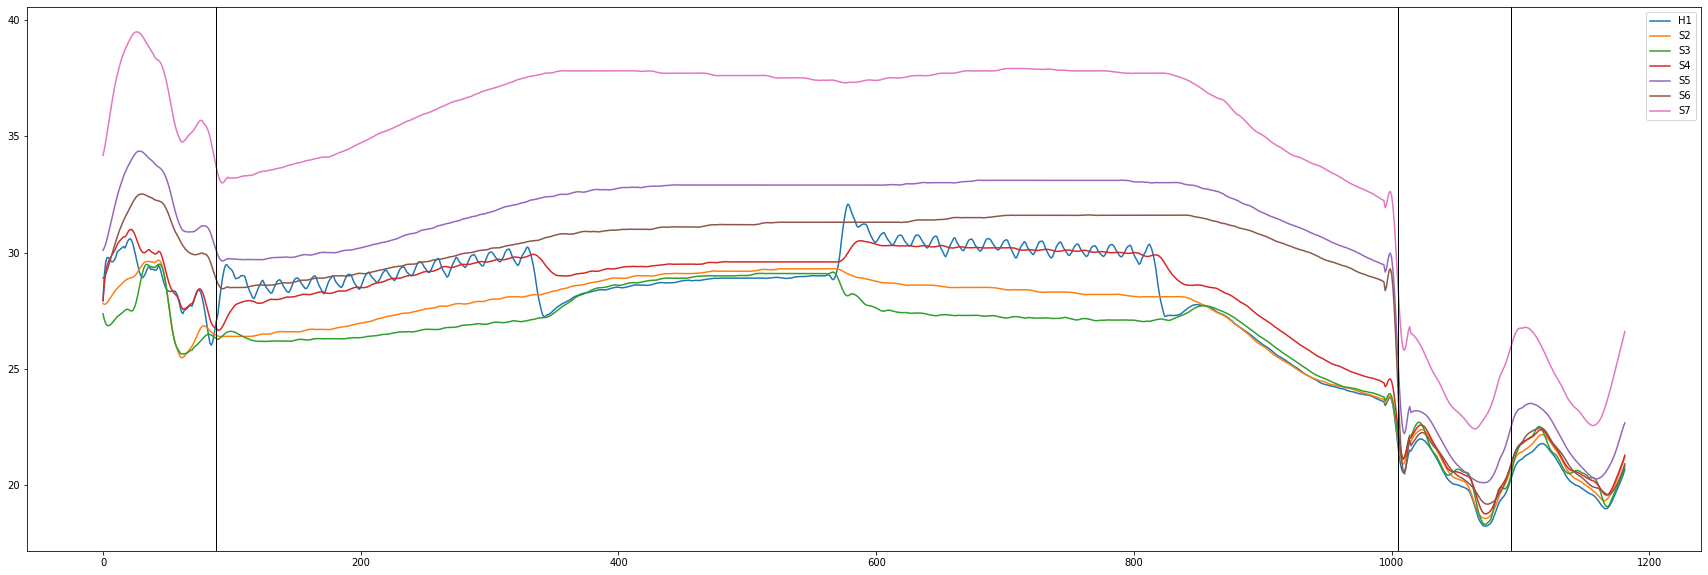

In [124]:
plt.figure(figsize=(30,10))
for i in range(pd_raw_X.shape[1]):
    plt.plot(pd_raw_X.iloc[:,i], label = pd_raw_X.columns[i])
for i in range(len(data_slicing_index) - 2):
    plt.axvline(x=data_slicing_index[i+1], color = 'black',linewidth=1)
plt.legend(bbox_to_anchor=(1.0, 1.0))

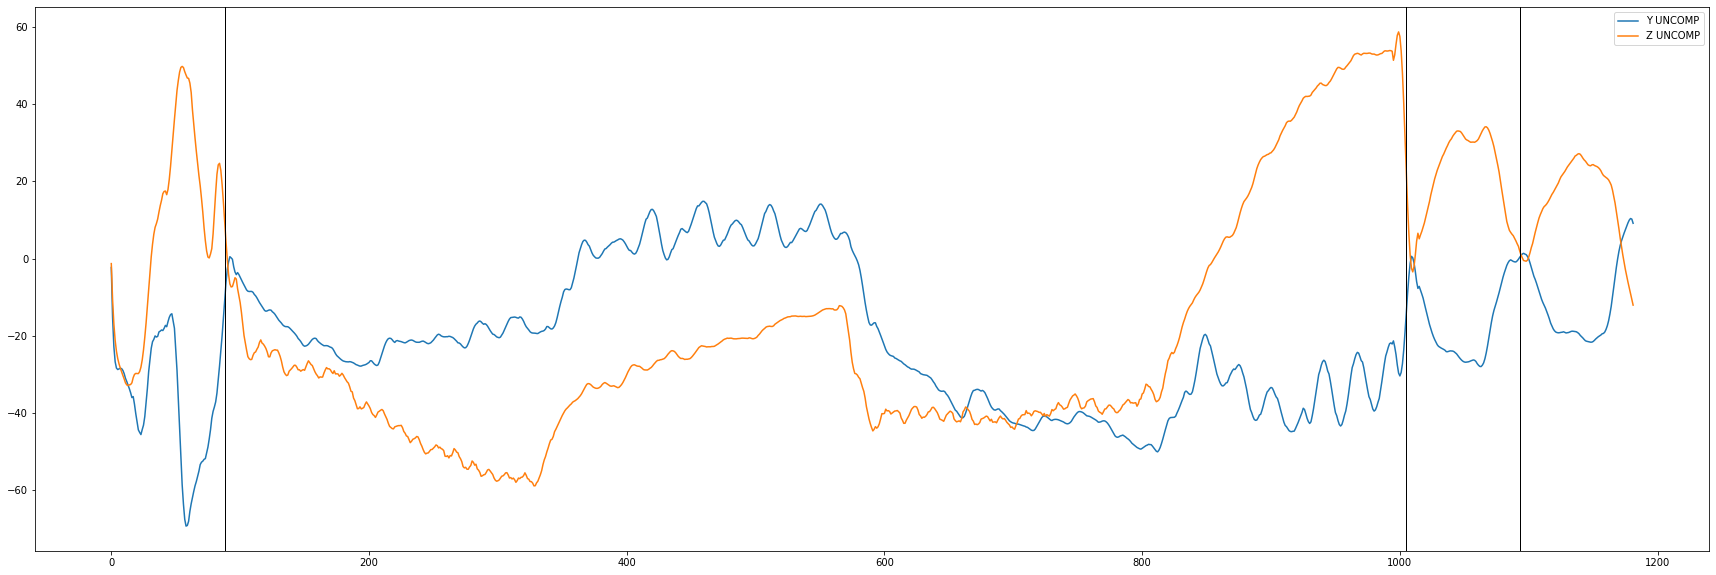

In [125]:
plt.figure(figsize=(30,10))
for i in range(pd_raw_Y.shape[1]):
    plt.plot(pd_raw_Y.iloc[:,i], label = pd_raw_Y.columns[i])
for i in range(len(data_slicing_index) - 2):
    plt.axvline(x=data_slicing_index[i+1], color = 'black',linewidth=1)
plt.legend(bbox_to_anchor=(1.0, 1.0))

## Scaling

In [126]:
#Scaler 적용
if Scale_Boolean == 1:
    
    if Time_Split_Boolean == 0:
        #X_Scaler = MinMaxScaler()
        #Y_Scaler = MinMaxScaler()
        X_Scaler = StandardScaler()
        Y_Scaler = StandardScaler()
        pd_raw_X = pd.DataFrame( X_Scaler.fit_transform(pd_raw_X), columns = pd_raw_X_columns )
        pd_raw_Y = pd.DataFrame( Y_Scaler.fit_transform(pd_raw_Y), columns = pd_raw_Y_columns )
        X_std = X_Scaler.scale_
        Y_std = Y_Scaler.scale_
        X_mean = X_Scaler.mean_
        Y_mean = Y_Scaler.mean_
        
    if Time_Split_Boolean == 1:
        X_Scaler = MinMaxScaler()
        Y_Scaler = MinMaxScaler()
        #X_Scaler = StandardScaler()
        #Y_Scaler = StandardScaler()
        pd_raw_X = pd.DataFrame( X_Scaler.fit_transform(pd_raw_X), columns = pd_raw_X_columns )
        pd_raw_Y = pd.DataFrame( Y_Scaler.fit_transform(pd_raw_Y), columns = pd_raw_Y_columns )


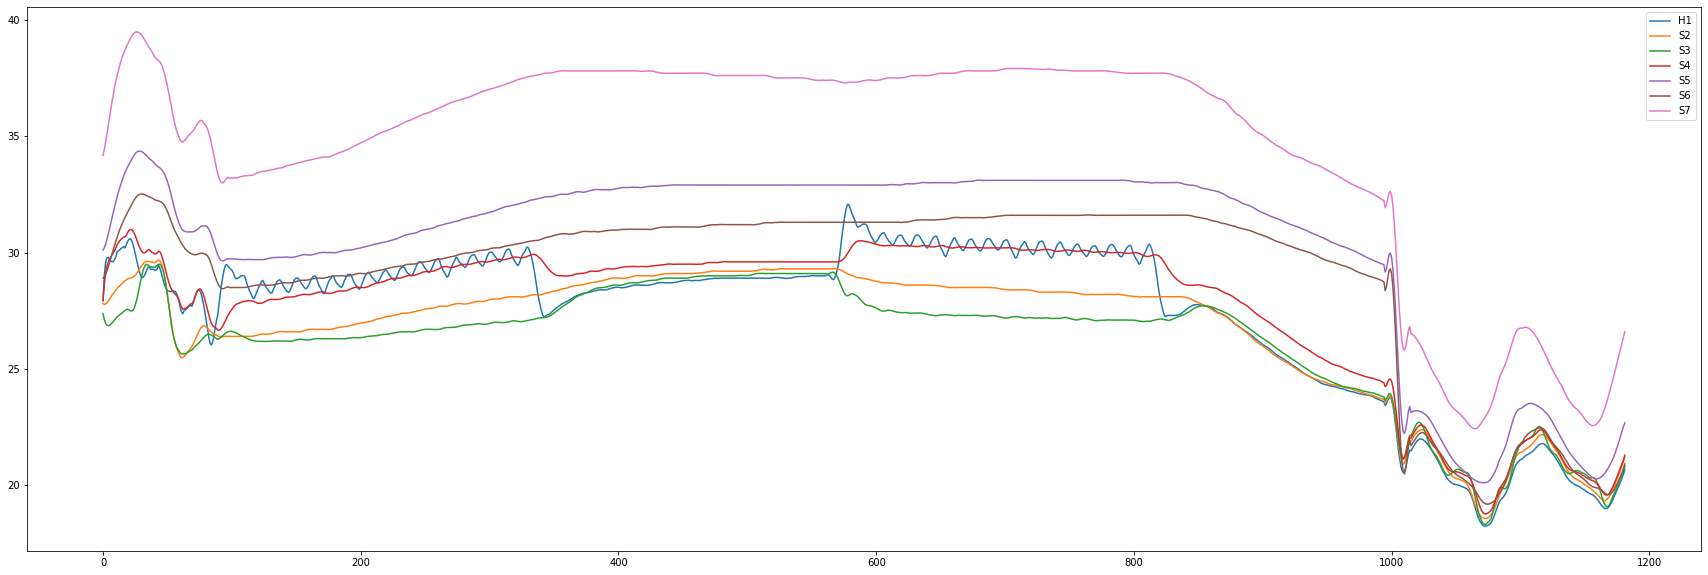

In [127]:
plt.figure(figsize=(30,10))
for i in range(pd_raw_X.shape[1]):
    plt.plot(pd_raw_X.iloc[:,i], label = pd_raw_X.columns[i])
plt.legend(bbox_to_anchor=(1.0, 1.0))

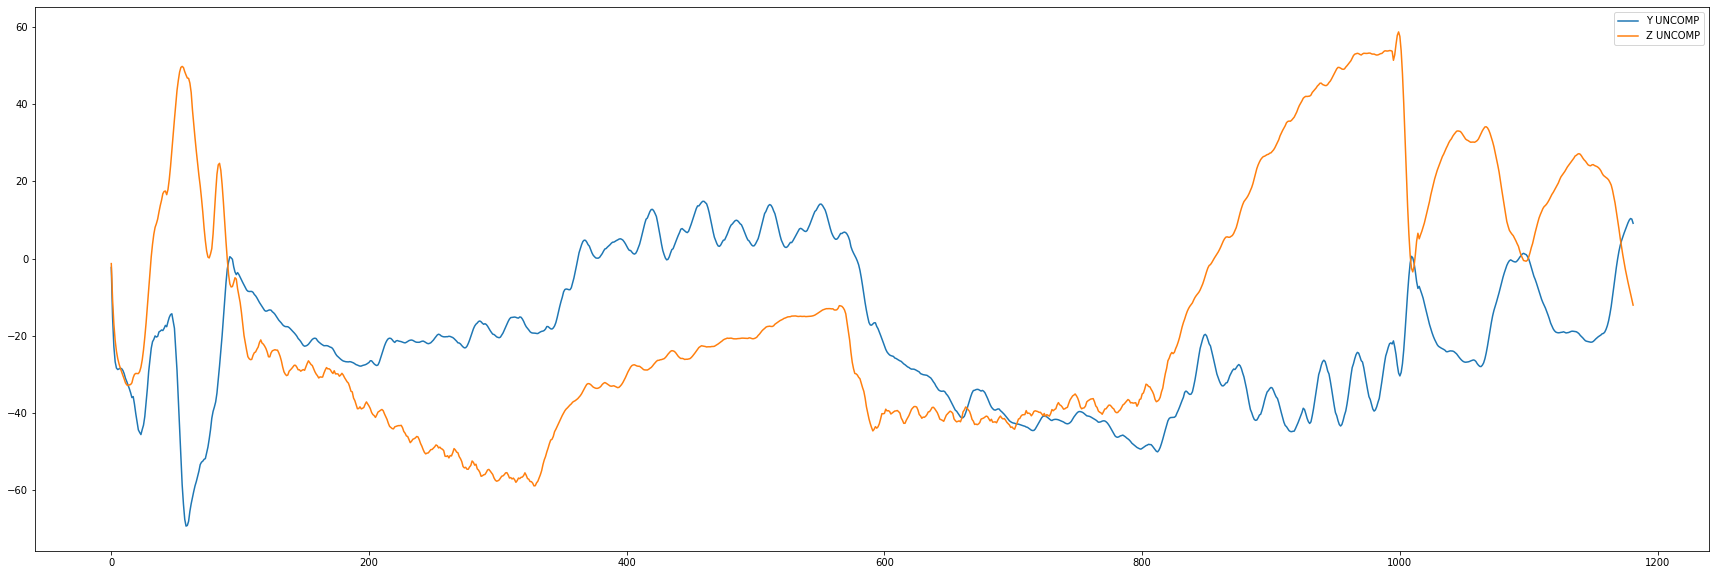

In [128]:
plt.figure(figsize=(30,10))
for i in range(pd_raw_Y.shape[1]):
    plt.plot(pd_raw_Y.iloc[:,i], label = pd_raw_Y.columns[i])
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [129]:
raise SystemExit("Exit from script")

sys.exit("Exit from script")

SystemExit: Exit from script

## Sliding Window(Batch 형태로 변환)

In [ ]:
def sliding_window(X, Y, n_steps, time, stride = 1, time_distributed = 0):
        
    # 1. X, Y time delta에 따라 나누기
    if time > 0:
        X = X[:-time]
        Y = Y[time:]
    elif time == 0:
        pass
    
    # 2. 결과로 낼 x, y
    result_X = np.array([X[0:n_steps].values])
    
    if time_distributed == 1:
        result_Y = np.array([Y[0:n_steps].values])
    else: 
        result_Y = np.array([Y[n_steps-1:n_steps].values])

    # 3. step과 stride에 맞춰서 concat, time_distributed 값에 따라 다르게 Y 만들기
    
    if time_distributed == 1:
        for i in tqdm(range(1, X.shape[0]),total=math.trunc(((len(X)-(n_steps-1)-1)/stride))):
            if i * stride + n_steps > X.shape[0]:
                #print("Data set finish") # add
                break
            result_X = np.concatenate((result_X, [X[i*stride: i*stride+n_steps].values]))
            result_Y = np.concatenate((result_Y, [Y[i*stride: i*stride+n_steps].values]))
            
    else:
        for i in tqdm(range(1, X.shape[0]),total=math.trunc(((len(X)-(n_steps-1)-1)/stride))):
            if i * stride + n_steps > X.shape[0]:
                #print("Data set finish") # add
                break
            result_X = np.concatenate((result_X, [X[i*stride: i*stride+n_steps].values]))
            result_Y = np.concatenate((result_Y, [Y[i*stride+n_steps-1: i*stride+n_steps].values]))

    return result_X, result_Y

## Batch화 하기

In [ ]:
def Batch_Input(one_pd_X,one_pd_Y,Time_Split_Boolean):
    box_size = int(one_pd_X.shape[0]/10) #들어온 데이터셋 10개 박스로 분할
    
    if Time_Split_Boolean == 1:
        n_steps = 30
        batch_stride = 1
        time_lag = 0
    if Time_Split_Boolean == 0:
        n_steps = 1800
        batch_stride = 60
        time_lag = 0        

    split_X,split_Y = sliding_window(X=one_pd_X, Y=one_pd_Y, n_steps=box_size, time=time_lag, stride=box_size, time_distributed=1)
    after_sliding_X_T, after_sliding_X_V, after_sliding_Y_T, after_sliding_Y_V = train_test_split(split_X, split_Y, test_size=0.3, random_state=11, shuffle=True)
        
    Big_split_X_T = pd.DataFrame(after_sliding_X_T[0,:])
    Big_split_Y_T = pd.DataFrame(after_sliding_Y_T[0,:])
    split_X_T,split_Y_T = sliding_window(X=Big_split_X_T, Y=Big_split_Y_T, n_steps=n_steps, time=time_lag, stride=batch_stride, time_distributed=0)   

    Small_Train_X = np.zeros((split_X_T.shape[0]*after_sliding_X_T.shape[0],split_X_T.shape[1],split_X_T.shape[2]))
    Small_Train_Y = np.zeros((split_Y_T.shape[0]*after_sliding_Y_T.shape[0],split_Y_T.shape[1],split_Y_T.shape[2]))
    Small_Valid_X = np.zeros((split_X_T.shape[0]*after_sliding_X_V.shape[0],split_X_T.shape[1],split_X_T.shape[2]))
    Small_Valid_Y = np.zeros((split_Y_T.shape[0]*after_sliding_Y_V.shape[0],split_Y_T.shape[1],split_Y_T.shape[2]))
    
    for i in range(after_sliding_X_T.shape[0]):
        Big_split_X_T = pd.DataFrame(after_sliding_X_T[i,:])
        Big_split_Y_T = pd.DataFrame(after_sliding_Y_T[i,:])
        split_X_T,split_Y_T = sliding_window(X=Big_split_X_T, Y=Big_split_Y_T, n_steps=n_steps, time=time_lag, stride=batch_stride, time_distributed=0)
        Small_Train_X = np.concatenate((Small_Train_X,split_X_T), axis = 0)
        Small_Train_Y = np.concatenate((Small_Train_Y,split_Y_T), axis = 0)
    for i in range(after_sliding_X_V.shape[0]):
        Big_split_X_V = pd.DataFrame(after_sliding_X_V[i,:])
        Big_split_Y_V = pd.DataFrame(after_sliding_Y_V[i,:])
        split_X_V,split_Y_V = sliding_window(X=Big_split_X_V, Y=Big_split_Y_V, n_steps=n_steps, time=time_lag, stride=batch_stride, time_distributed=0)
        Small_Valid_X = np.concatenate((Small_Valid_X,split_X_V), axis = 0)
        Small_Valid_Y = np.concatenate((Small_Valid_Y,split_Y_V), axis = 0)
    
    ##ML용 Data Set 생성
    ML_pd_raw_X_T = after_sliding_X_T.reshape(-1,after_sliding_X_T.shape[2])
    ML_pd_raw_Y_T = after_sliding_Y_T.reshape(-1,after_sliding_Y_T.shape[2])
    ML_pd_raw_X_V = after_sliding_X_V.reshape(-1,after_sliding_X_V.shape[2])
    ML_pd_raw_Y_V = after_sliding_Y_V.reshape(-1,after_sliding_Y_V.shape[2])

    return Small_Train_X,Small_Train_Y,Small_Valid_X,Small_Valid_Y,ML_pd_raw_X_T,ML_pd_raw_Y_T,ML_pd_raw_X_V,ML_pd_raw_Y_V

In [ ]:
split_X_T1,split_Y_T1,split_X_V1,split_Y_V1,ML_pd_raw_X_T1,ML_pd_raw_Y_T1,ML_pd_raw_X_V1,ML_pd_raw_Y_V1 \
= Batch_Input(pd_raw_X.iloc[data_slicing_index[0]:data_slicing_index[1],:],pd_raw_Y.iloc[data_slicing_index[0]:data_slicing_index[1],:],Time_Split_Boolean)
split_X_T2,split_Y_T2,split_X_V2,split_Y_V2,ML_pd_raw_X_T2,ML_pd_raw_Y_T2,ML_pd_raw_X_V2,ML_pd_raw_Y_V2 \
= Batch_Input(pd_raw_X.iloc[data_slicing_index[1]:data_slicing_index[2],:],pd_raw_Y.iloc[data_slicing_index[1]:data_slicing_index[2],:],Time_Split_Boolean)
split_X_T3,split_Y_T3,split_X_V3,split_Y_V3,ML_pd_raw_X_T3,ML_pd_raw_Y_T3,ML_pd_raw_X_V3,ML_pd_raw_Y_V3 \
= Batch_Input(pd_raw_X.iloc[data_slicing_index[2]:data_slicing_index[3],:],pd_raw_Y.iloc[data_slicing_index[2]:data_slicing_index[3],:],Time_Split_Boolean)

In [ ]:
Train_X = np.concatenate((split_X_T1,split_X_T2,split_X_T3), axis = 0)
Train_Y = np.concatenate((split_Y_T1,split_Y_T2,split_Y_T3), axis = 0)
Valid_X = np.concatenate((split_X_V1,split_X_V2,split_X_V3), axis = 0)
Valid_Y = np.concatenate((split_Y_V1,split_Y_V2,split_Y_V3), axis = 0)
ML_pd_raw_X_T = pd.DataFrame( np.concatenate((ML_pd_raw_X_T1,ML_pd_raw_X_T2,ML_pd_raw_X_T3), axis = 0) , columns = pd_raw_X_columns)
ML_pd_raw_Y_T = pd.DataFrame( np.concatenate((ML_pd_raw_Y_T1,ML_pd_raw_Y_T2,ML_pd_raw_Y_T3), axis = 0) , columns = pd_raw_Y_columns)
ML_pd_raw_X_V = pd.DataFrame( np.concatenate((ML_pd_raw_X_V1,ML_pd_raw_X_V2,ML_pd_raw_X_V3), axis = 0) , columns = pd_raw_X_columns)
ML_pd_raw_Y_V = pd.DataFrame( np.concatenate((ML_pd_raw_Y_V1,ML_pd_raw_Y_V2,ML_pd_raw_Y_V3), axis = 0) , columns = pd_raw_Y_columns)

# GRU Layer

In [ ]:
last_return_boolean = 0

In [ ]:
# 합성곱 층을 포함한 GRU 모형의 골격 만들기
print("Batch number:",Train_X.shape[0])
input_length = Train_X.shape[2]

model = keras.models.Sequential()
if Cv_Boolean == 1:
    ## filter = 5 10 30 60
    ## kernel_size = 10 30 60 120 300
    ## strides = /2 /3 /5 /10
    model.add( keras.layers.Conv1D(filters = 5, kernel_size = 5, strides = 3, padding = 'valid', input_shape=[None,input_length]) )
    model.add( keras.layers.BatchNormalization())
    model.add( keras.layers.GRU(4, return_sequences = True)) 
    #model.add( keras.layers.Dropout(0.5) )
    model.add( keras.layers.LayerNormalization() )
elif Cv_Boolean == 0:
    model.add( keras.layers.GRU(4, return_sequences = True, input_shape=[None,input_length]) )
    #model.add( keras.layers.Dropout(0.2) )
    model.add( keras.layers.LayerNormalization() )
    
#model.add( keras.layers.GRU(32, return_sequences = True ))
#model.add( keras.layers.Dropout(0.5) )
#model.add( keras.layers.LayerNormalization() )

if last_return_boolean == 1:
    model.add( keras.layers.GRU(4, return_sequences = True) )
    #model.add( keras.layers.Dropout(0.2) )
    model.add( keras.layers.LayerNormalization() )
    model.add( keras.layers.Dense(pd_raw_Y.shape[1]) )
else:
    model.add( keras.layers.GRU(4, return_sequences = False) ) 
    #model.add( keras.layers.Dropout(0.2) )
    model.add( keras.layers.LayerNormalization() )
    model.add( keras.layers.Dense(pd_raw_Y.shape[1]) )
#plot_model(model)
model.summary()

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./GRU.hdf5',
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
Optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=Optimizer)

In [ ]:
if last_return_boolean == 1:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta= 0.01, patience=3)
    history = model.fit(Train_X, Train_Y, epochs=20, validation_data=(Valid_X, Valid_Y), callbacks=[es_callback,model_checkpoint_callback] )
else:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta= 0.01, patience=3)
    history = model.fit(Train_X, Train_Y.reshape(Train_Y.shape[0],pd_raw_Y.shape[1]), epochs=20, validation_data=( Valid_X, Valid_Y.reshape(Valid_Y.shape[0],pd_raw_Y.shape[1]) ), callbacks=[es_callback,model_checkpoint_callback] )

In [ ]:
#pd.DataFrame(history.history).loc[:,['loss','val_loss']] = Y_std*(pd.DataFrame(history.history).loc[:,['loss','val_loss']]) # 실제 Scaler로 MSE 변환
pd.DataFrame(history.history).loc[:,['loss','val_loss']].plot(figsize=(8,5))
plt.xlabel('Iteration(epoch)')
plt.ylabel('Mean Squared Error')
plt.grid(True)

In [ ]:
predict_y = model.predict(Valid_X)

# Visualization

In [ ]:
# 그래프 Label용 문자열 데이터 생성
column_list = data_train.columns.tolist()
y_column = []
for s in column_list:
      if 'DISP' in s:
        y_column.append(s)

In [ ]:
#predict_y = pd.DataFrame(Y_Scaler.inverse_transform(predict_y))
#actual_y = np.array(Valid_Y).reshape(-1,pd_raw_Y.shape[1])
#actual_y = pd.DataFrame(Y_Scaler.inverse_transform(actual_y))

In [ ]:
predict_y = pd.DataFrame(predict_y)
actual_y = np.array(Valid_Y).reshape(-1,pd_raw_Y.shape[1])
actual_y = pd.DataFrame(actual_y)

In [ ]:
for i in range(actual_y.shape[1]):
    plt.figure(figsize=(10,6))
    plt.plot(predict_y.iloc[:,i],label="Predict "+y_column[i])
    plt.plot(actual_y.iloc[:,i],label="Actual "+y_column[i])
    plt.ylabel('Displacement(um)')
    plt.xlabel('Time(1m)')
    plt.legend()
    plt.show()
    print("MSE:",np.sum((predict_y.iloc[:,i] - actual_y.iloc[:,i])**2)/len(actual_y))

In [ ]:
raise SystemExit("Exit from script")

sys.exit("Exit from script")

# XGboost

In [152]:
ML_pd_raw_X_T = pd_raw_X.iloc[:data_slicing_index[2],:]
ML_pd_raw_Y_T = pd_raw_Y.iloc[:data_slicing_index[2],:]
ML_pd_raw_X_V = pd_raw_X.iloc[data_slicing_index[2]:,:]
ML_pd_raw_Y_V = pd_raw_Y.iloc[data_slicing_index[2]:,:]

In [219]:
if Scale_Boolean ==  1:
    ML_actual_y = Y_Scaler.inverse_transform(ML_pd_raw_Y_V)
else:
    ML_actual_y = np.array(ML_pd_raw_Y_V.values)

In [220]:
def one_column_inverse_transform(array,mean,std):
    inverse_scaled_array = np.zeros(len(array))
    inverse_scaled_array[:] = std*array[:] + mean
    return inverse_scaled_array

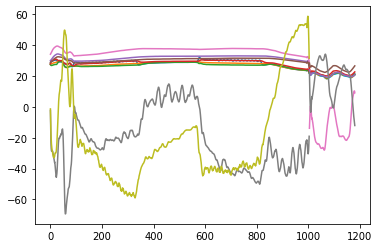

In [235]:
plt.plot(ML_pd_raw_X_T)
plt.plot(ML_pd_raw_Y_T)
plt.plot(ML_pd_raw_X_V)
plt.plot(ML_pd_raw_Y_V)

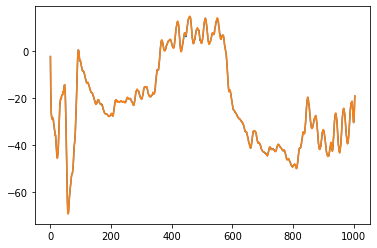

In [239]:
XGB_Y = XGBRegressor()
XGB_Y.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,0])

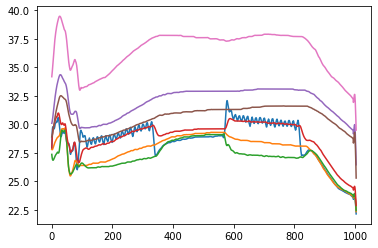

In [245]:
plt.plot(ML_pd_raw_X_T)

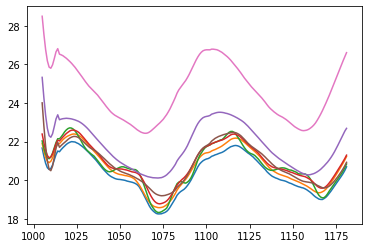

In [246]:
plt.plot(ML_pd_raw_X_V)

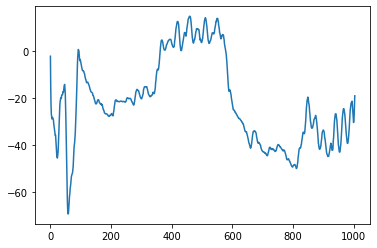

In [243]:
plt.plot(XGB_Y.predict(ML_pd_raw_X_T))

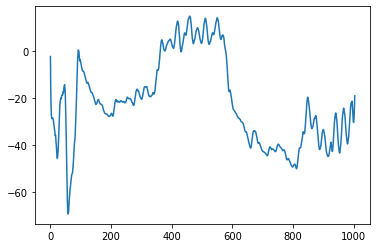

In [241]:
plt.plot(ML_pd_raw_Y_T.iloc[:,0])

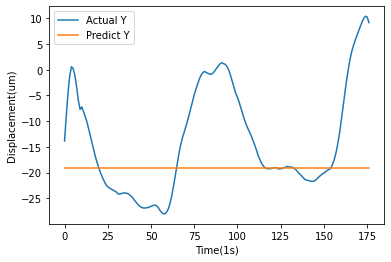

MSE: 136.90331192466712


In [221]:
XGB_Y = XGBRegressor()
XGB_Y.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,0])

y_pred_xgb_y = XGB_Y.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,0],label="Actual Y")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_xgb_y,Y_mean[0],Y_std[0]),label="Predict Y")
else:
    plt.plot(y_pred_xgb_y,label="Predict Y")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], one_column_inverse_transform(y_pred_xgb_y,Y_mean[0],Y_std[0])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], y_pred_xgb_y) ) 

<AxesSubplot:title={'center':'Weight'}, xlabel='F score', ylabel='Features'>

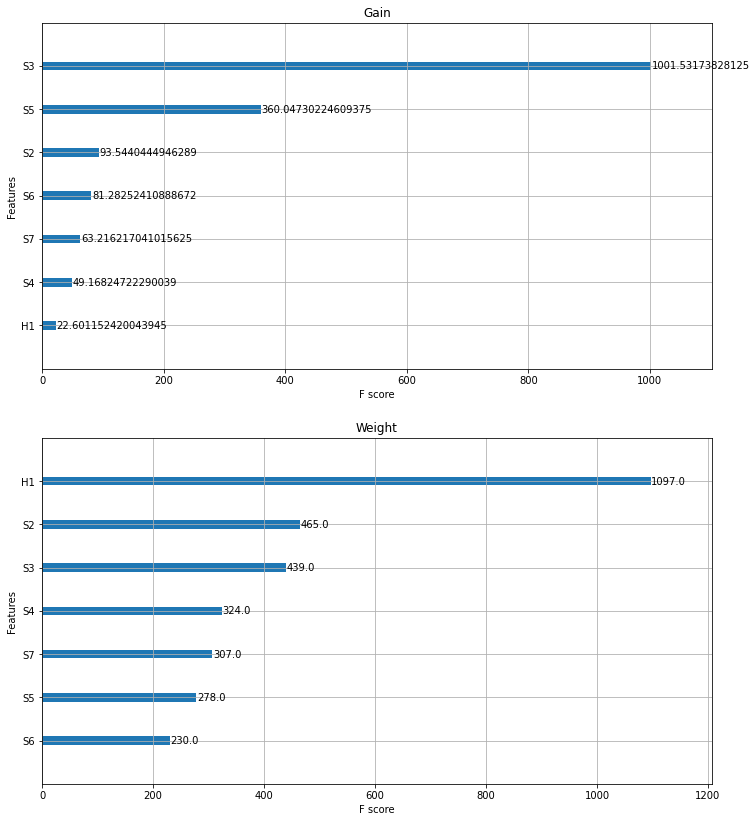

In [222]:
fig, ax = plt.subplots(2,1,figsize=(12, 14))
plot_importance(XGB_Y, ax=ax[0], importance_type='gain', title='Gain')
plot_importance(XGB_Y, ax=ax[1], importance_type='weight', title='Weight')

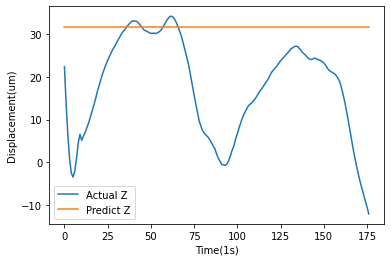

MSE: 327.00422219836605


In [223]:
XGB_Z = XGBRegressor()
XGB_Z.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,1])

y_pred_xgb_z = XGB_Z.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,1],label="Actual Z")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_xgb_z,Y_mean[1],Y_std[1]),label="Predict Z")
else:
    plt.plot(y_pred_xgb_z,label="Predict Z")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], one_column_inverse_transform(y_pred_xgb_z,Y_mean[1],Y_std[1])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], y_pred_xgb_z) )

<AxesSubplot:title={'center':'Weight'}, xlabel='F score', ylabel='Features'>

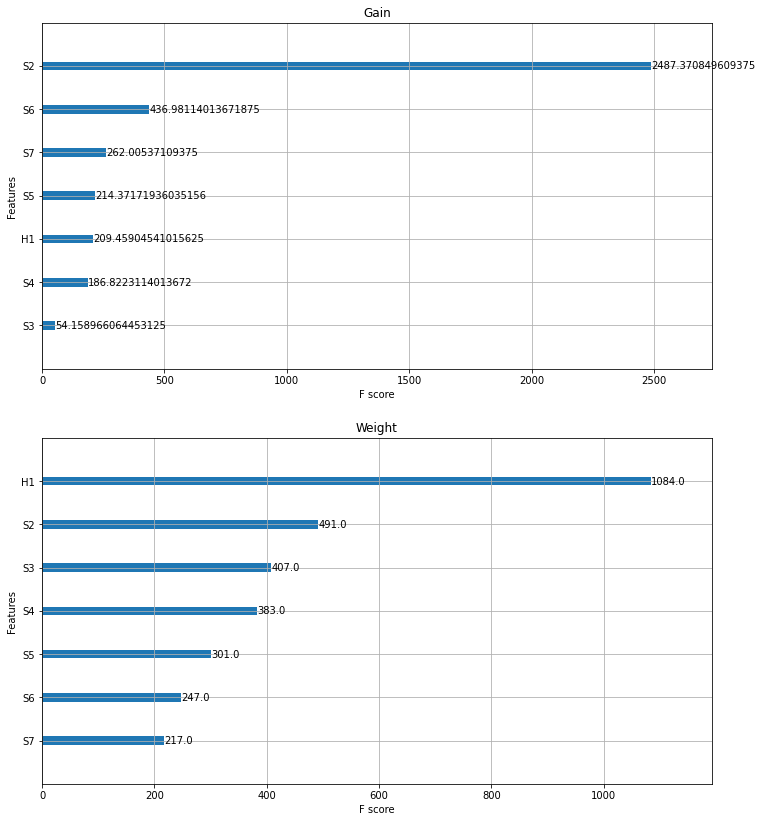

In [224]:
fig, ax = plt.subplots(2,1,figsize=(12, 14))
plot_importance(XGB_Z, ax=ax[0], importance_type='gain', title='Gain')
plot_importance(XGB_Z, ax=ax[1], importance_type='weight', title='Weight')

# Random Forest

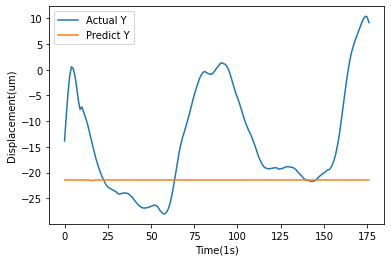

MSE: 166.88228856205654


In [225]:
RF_Y = RandomForestRegressor()
RF_Y.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,0])

y_pred_rf_y = RF_Y.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,0],label="Actual Y")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_rf_y,Y_mean[0],Y_std[0]),label="Predict Y")
else:
    plt.plot(y_pred_rf_y,label="Predict Y")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], one_column_inverse_transform(y_pred_rf_y,Y_mean[0],Y_std[0])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], y_pred_rf_y) )

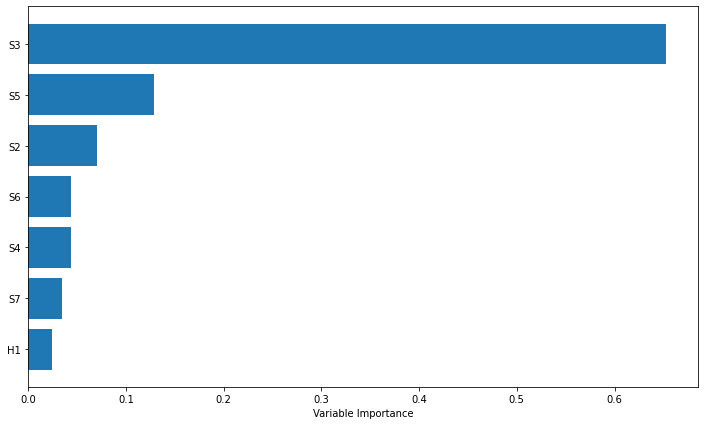

In [226]:
#피처 중요도 도표 그리기
featureimportance = RF_Y.feature_importances_

#가장 높은 중요도 기준으로 스케일링
sorted_idx = np.argsort(featureimportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.figure(figsize=(12,7))
plt.barh(barPos, featureimportance[sorted_idx], align='center')
plt.yticks(barPos, pd_raw_X.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

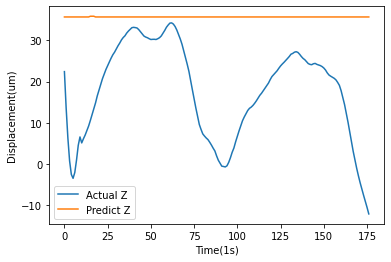

MSE: 454.64174165015913


In [227]:
RF_Z = RandomForestRegressor()
RF_Z.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,1])

y_pred_rf_z = RF_Z.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,1],label="Actual Z")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_rf_z,Y_mean[1],Y_std[1]),label="Predict Z")
else:
    plt.plot(y_pred_rf_z,label="Predict Z")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], one_column_inverse_transform(y_pred_rf_z,Y_mean[1],Y_std[1])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], y_pred_rf_z) )

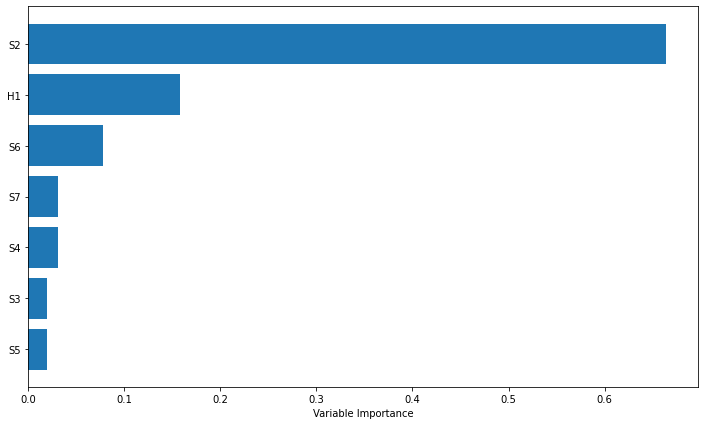

In [228]:
#피처 중요도 도표 그리기
featureimportance = RF_Z.feature_importances_

#가장 높은 중요도 기준으로 스케일링
sorted_idx = np.argsort(featureimportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.figure(figsize=(12,7))
plt.barh(barPos, featureimportance[sorted_idx], align='center')
plt.yticks(barPos, pd_raw_X.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

# SVR

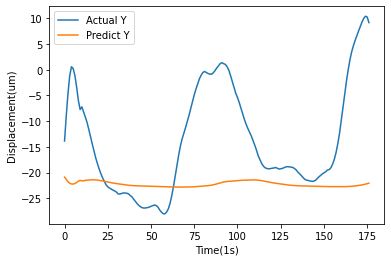

MSE: 178.74099033199943


In [229]:
SVR_Y = SVR(kernel='rbf')
SVR_Y.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,0])

y_pred_svr_y = SVR_Y.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,0],label="Actual Y")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_svr_y,Y_mean[0],Y_std[0]),label="Predict Y")
else:
    plt.plot(y_pred_svr_y,label="Predict Y")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], one_column_inverse_transform(y_pred_svr_y,Y_mean[0],Y_std[0])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], y_pred_svr_y) )

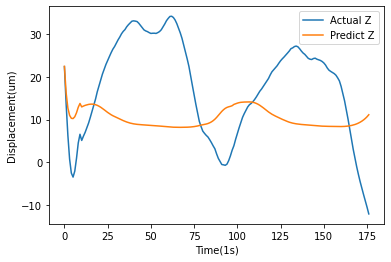

MSE: 213.1492727936087


In [230]:
SVR_Z = SVR(kernel='rbf')
SVR_Z.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,1])

y_pred_svr_z = SVR_Z.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,1],label="Actual Z")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_svr_z,Y_mean[1],Y_std[1]),label="Predict Z")
else:
    plt.plot(y_pred_svr_z,label="Predict Z")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], one_column_inverse_transform(y_pred_svr_z,Y_mean[1],Y_std[1])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], y_pred_svr_z) )

# MLR

In [231]:
## Linear Coefficient Plot 함수 Define
def linear_coef_plot(coef, names = list(pd_raw_X.columns)):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(12,7))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel('Variable Coefficient')
    plt.show()

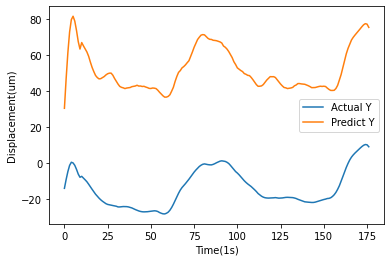

MSE: 4316.267958257795


In [247]:
MLR_Y = LinearRegression()
MLR_Y.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,0])

y_pred_mlr_y = MLR_Y.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,0],label="Actual Y")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_mlr_y,Y_mean[0],Y_std[0]),label="Predict Y")
else:
    plt.plot(y_pred_mlr_y,label="Predict Y")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], one_column_inverse_transform(y_pred_mlr_y,Y_mean[0],Y_std[0])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,0], y_pred_mlr_y) )

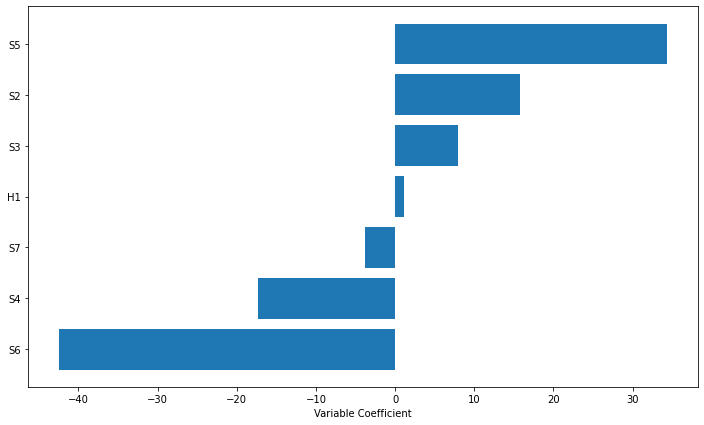

In [248]:
linear_coef_plot(MLR_Y.coef_.reshape(-1,))

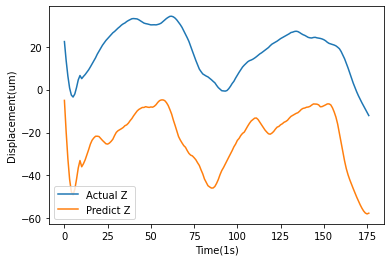

MSE: 1696.6137805125145


In [249]:
MLR_Z = LinearRegression()
MLR_Z.fit(ML_pd_raw_X_T, ML_pd_raw_Y_T.iloc[:,1])

y_pred_mlr_z = MLR_Z.predict(ML_pd_raw_X_V)
plt.plot(ML_actual_y[:,1],label="Actual Z")
if Scale_Boolean == 1:
    plt.plot(one_column_inverse_transform(y_pred_mlr_z,Y_mean[1],Y_std[1]),label="Predict Z")
else:
    plt.plot(y_pred_mlr_z,label="Predict Z")
plt.ylabel('Displacement(um)')
plt.xlabel('Time(1s)')
plt.legend()
plt.show()

if Scale_Boolean == 1:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], one_column_inverse_transform(y_pred_mlr_z,Y_mean[1],Y_std[1])) )
else:
    print("MSE:",mean_squared_error(ML_actual_y[:,1], y_pred_mlr_z) )

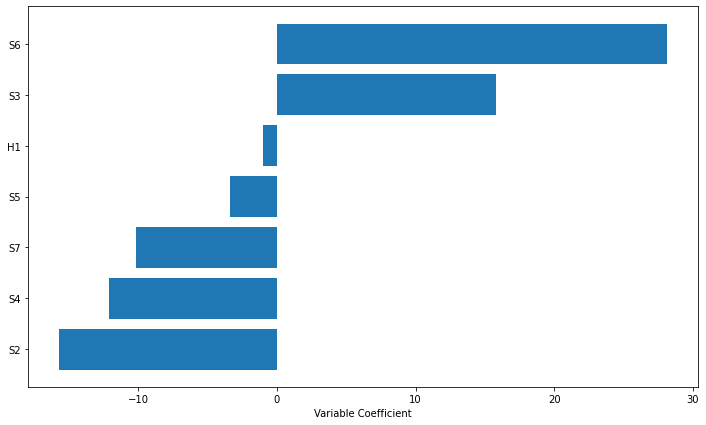

In [250]:
linear_coef_plot(MLR_Z.coef_.reshape(-1,))

## Timeseries Clustering

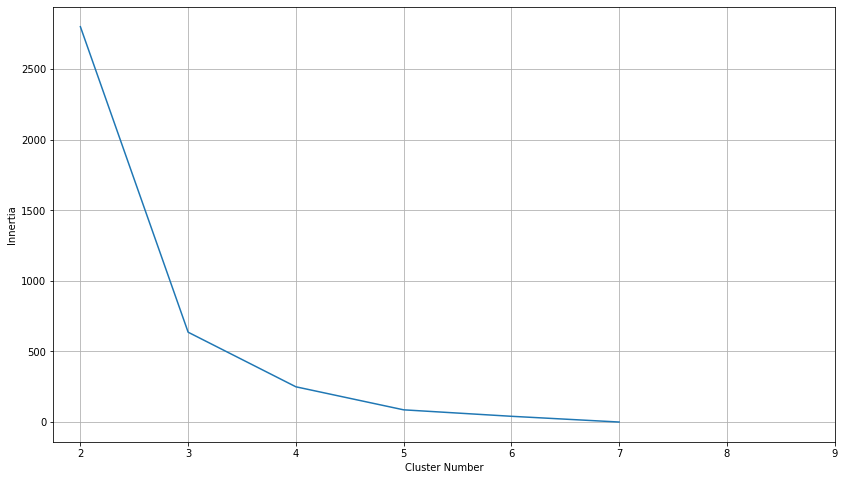

In [251]:
KM_history = []
for i in range(2,10):
    cluster_num = i
    KM_model = TimeSeriesKMeans(n_clusters = cluster_num, random_state = 42, metric = 'euclidean')
    KM_model.fit(pd_raw_X.transpose())
    KM_history.append(KM_model.inertia_)
plt.figure(figsize=(14,8))
plt.plot(range(2,len(KM_history)+2), KM_history)    
plt.xticks( range(2,len(KM_history)+2) )
plt.xlabel('Cluster Number')
plt.ylabel('Innertia')
plt.grid(True)
plt.show()

In [252]:
cluster_num = 8
KM_model = TimeSeriesKMeans(n_clusters = cluster_num, random_state = 42, metric = 'euclidean')
KM_model.fit(pd_raw_X.transpose())
KM_history.append(KM_model.inertia_)

(7,)


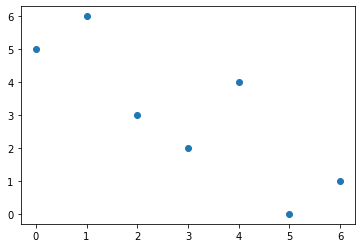

In [253]:
KM_pred = KM_model.predict(pd_raw_X.transpose())
print(KM_pred.shape)
plt.scatter(range(KM_pred.shape[0]),KM_pred)
plt.show()

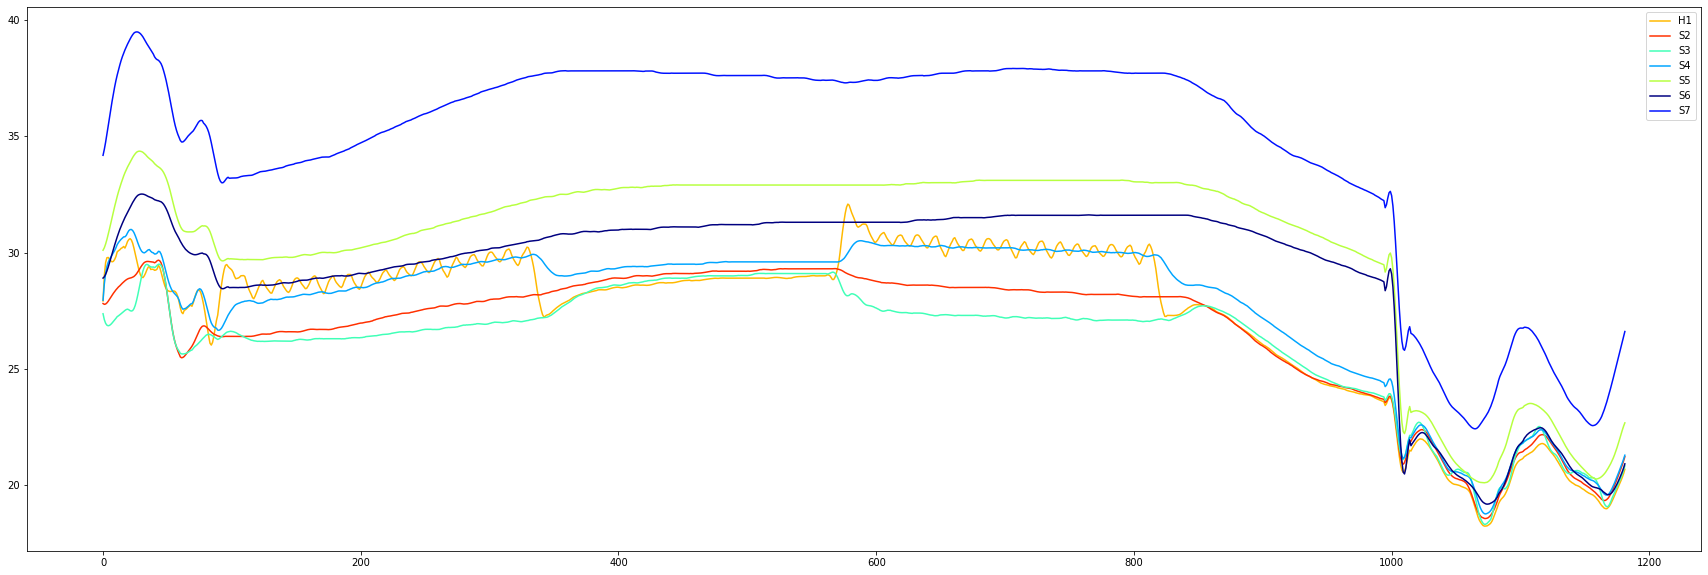

In [254]:
plt.figure(figsize=(30,10))
colors = plt.cm.jet(np.linspace(0,1,cluster_num))
for i in range(pd_raw_X.shape[1]):
    plt.plot(pd_raw_X.iloc[:,i], label = pd_raw_X.columns[i], color = colors[KM_pred[i]])
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [255]:
raise SystemExit("Exit from script")

sys.exit("Exit from script")

SystemExit: Exit from script

## CNN Layer

In [ ]:
Train_X = Train_X[...,np.newaxis]
Train_Y = Train_Y[...,np.newaxis]
Valid_X = Valid_X[...,np.newaxis]
Valid_Y = Valid_Y[...,np.newaxis]

In [ ]:
# 합성곱 층을 포함한 GRU 모형의 골격 만들기
print("Batch number:",Train_X.shape[0])

model = keras.models.Sequential()
model.add( keras.layers.Conv2D(filters = 8, kernel_size = 3, strides = (1,1), padding = 'same', input_shape=[Train_X.shape[1],Train_X.shape[2],Train_X.shape[3]], activation = 'relu') )
model.add( keras.layers.BatchNormalization() )

model.add( keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)) )

model.add( keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu') )
model.add( keras.layers.BatchNormalization() )

model.add( keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)) )

model.add( keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu') )
model.add( keras.layers.BatchNormalization() )

model.add( keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu') )
model.add( keras.layers.BatchNormalization() )
model.add( keras.layers.Dropout(0.2) )

model.add( keras.layers.Flatten())

model.add( keras.layers.Dense(Train_Y.shape[2]) )
#plot_model(model)
model.summary()

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./GRU.hdf5',
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=False)

In [ ]:
Optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=Optimizer)

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta= 0.005, patience=3)
history = model.fit(Train_X, Train_Y.reshape(Train_Y.shape[0],pd_raw_Y.shape[1]), epochs=20, validation_data=( Valid_X, Valid_Y.reshape(Valid_Y.shape[0],pd_raw_Y.shape[1]) ), callbacks=[es_callback,model_checkpoint_callback] )

In [ ]:
pd.DataFrame(history.history).loc[:,['loss','val_loss']].plot(figsize=(8,5))
plt.xlabel('Iteration(epoch)')
plt.ylabel('Mean Squared Error')
plt.grid(True)

In [ ]:
# 그래프 Label용 문자열 데이터 생성
column_list = data_train.columns.tolist()
y_column = []
for s in column_list:
      if 'DISP' in s:
        y_column.append(s)

In [ ]:
predict_y = model.predict(Valid_X)

In [ ]:
predict_y = pd.DataFrame(Y_Scaler.inverse_transform(predict_y))
actual_y = np.array(Valid_Y).reshape(-1,pd_raw_Y.shape[1])
actual_y = pd.DataFrame(Y_Scaler.inverse_transform(actual_y))

In [ ]:
for i in range(actual_y.shape[1]):
    plt.figure(figsize=(10,6))
    plt.plot(predict_y.iloc[:,i],label="Predict "+y_column[i])
    plt.plot(actual_y.iloc[:,i],label="Actual "+y_column[i])
    plt.ylabel('Displacement(um)')
    plt.xlabel('Time(1m)')
    plt.legend()
    plt.show()
    print("MSE:",np.sum((predict_y.iloc[:,i] - actual_y.iloc[:,i])**2)/len(actual_y))

In [ ]:
def make_gradcam_heatmap(img_array, model, conv_layer_name, X_size, Y_size, pred_index = None):
    # 입력에 따른 피처 맵 모델 생성
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(conv_layer_name).output, model.output] )
    # 출력에 따른 Gradient 계산 함수
    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:,pred_index]
        
    # 예측된 값에 대한 Gradient 호출
    grads = tape.gradient(class_channel, conv_layer_output)
    
    # 각 피쳐 맵에 대한 가중치 산출
    pooled_grads = tf.reduce_mean(grads, axis = (0,1,2))
    
    # 계산된 가중치와 해당 레이러를 곱하여 얼마나 중요도를 가지는지 히트맵 계산
    conv_layer_output = conv_layer_output[0]
    heatmap = conv_layer_output @ pooled_grads[...,tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = abs(heatmap) ## ReLu 방지를 위해 도입
    print(heatmap)
    
    # 시각화를 위해 0-1 범위로 정규화 및 ReLu 수행
    heatmap = tf.maximum(heatmap,0) / tf.math.reduce_max(heatmap)
    heatmap = np.uint8(255*heatmap)
    heatmap = heatmap[...,np.newaxis]
    heatmap = tf.image.resize(heatmap,(X_size, Y_size))
            
    plt.imshow(heatmap, cmap = cm.jet)

In [ ]:
make_gradcam_heatmap(Valid_X,model,model.get_layer(index = 8).name, Train_X.shape[1], Train_X.shape[2])